In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import silhouette_score


# Loading

In [182]:
file_path = '/content/costs_data.csv'

df_src = pd.read_csv(file_path)

df_src

,P/O No.,P/O Date,Vendor Name,Job Code,Job Name,Ref.Code,Deli. Date,Cost Code,Material Code,Unit,Qty,Price/Unit,Amount,Discount,VAT,Net Amount
0,POSE23080183,2023-08-11 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10 00:00:00,M220905,P1901200402702,กระป๋อง,2.00,38.00,76.00,0.00,5.32,81.32
1,POSE23080183,2023-08-11 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10 00:00:00,M220905,P1901201103402,กระป๋อง,4.00,38.00,152.00,0.00,10.64,162.64
2,POSE23080183,2023-08-11 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10 00:00:00,M220905,P1901200703002,กระป๋อง,4.00,38.00,152.00,0.00,10.64,162.64
3,POSE23080183,2023-08-11 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10 00:00:00,U220000,P1901200903202,กระป๋อง,2.00,38.00,76.00,0.00,5.32,81.32
4,POSE23080183,2023-08-11 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10 00:00:00,M220905,P7001020100901,Kg/กก.,1.00,110.00,110.00,0.00,7.70,117.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36262,POGI24050026,2024-05-03 00:00:00,บมจ.บีพีเอส เทคโนโลยี,2,EE,65G05,2024-05-06 00:00:00,M220905,P3111109001001,EA,"2,000.00",0.80,"1,600.00",0.00,112.00,"1,712.00"
36263,POGI24050026,2024-05-03 00:00:00,บมจ.บีพีเอส เทคโนโลยี,2,EE,65G05,2024-05-06 00:00:00,M220905,P3111100501001,EA,"2,000.00",3.25,"6,500.00","3,120.00",236.60,"3,616.60"
36264,POGI24050027,2024-05-03 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,65G05,2024-05-06 00:00:00,M220905,P3120500503001,EA,500.00,5.20,"2,600.00",0.00,182.00,"2,782.00"
36265,POGI24050027,2024-05-03 00:00:00,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,65G05,2024-05-06 00:00:00,M220905,P3120500501001,EA,500.00,3.80,"1,900.00",0.00,133.00,"2,033.00"


# Cleaning

In [183]:
df_src.isna().sum()

P/O No.           0
P/O Date          0
Vendor Name       0
Job Code          0
Job Name          0
Ref.Code          0
Deli. Date        0
Cost Code        71
Material Code     0
Unit              0
Qty               0
Price/Unit        0
Amount            0
Discount          0
VAT               0
Net Amount        0
dtype: int64

In [184]:
# Decide to drop missing values because cost code cannot be infered (specific categories), and it is not that many
df_clean = df_src.dropna(subset=['Cost Code'])

# Domain specific cleaning: Cost code begins with a letter, we will categorize by that
df_clean['Cost Code'] = df_clean['Cost Code'].astype(str).str[0]

df_clean.isna().sum()

<ipython-input-184-ad3d9c242144>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



P/O No.          0
P/O Date         0
Vendor Name      0
Job Code         0
Job Name         0
Ref.Code         0
Deli. Date       0
Cost Code        0
Material Code    0
Unit             0
Qty              0
Price/Unit       0
Amount           0
Discount         0
VAT              0
Net Amount       0
dtype: int64

In [185]:
# Checks out, ref code is a site, Job code has 6 distinct: AC/EE/OH/SN/OTHER/FP and cost code has 5: G/L/M/PU/SUB
df_clean.nunique()

P/O No.           8175
P/O Date           511
Vendor Name        234
Job Code             6
Job Name             6
Ref.Code            10
Deli. Date         605
Cost Code            5
Material Code     8966
Unit                70
Qty                960
Price/Unit        4907
Amount           10120
Discount          7077
VAT              13140
Net Amount       14312
dtype: int64

In [186]:
df_clean['Cost Code'].unique()

array(['M', 'U', 'G', 'S', 'L'], dtype=object)

In [187]:
df_clean['Job Name'].unique()

array(['EE', 'AC', 'Over Head', 'SN', 'OTHER', 'FP'], dtype=object)

In [188]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36196 entries, 0 to 36266
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   P/O No.        36196 non-null  object
 1   P/O Date       36196 non-null  object
 2   Vendor Name    36196 non-null  object
 3   Job Code       36196 non-null  int64 
 4   Job Name       36196 non-null  object
 5   Ref.Code       36196 non-null  object
 6   Deli. Date     36196 non-null  object
 7   Cost Code      36196 non-null  object
 8   Material Code  36196 non-null  object
 9   Unit           36196 non-null  object
 10  Qty            36196 non-null  object
 11  Price/Unit     36196 non-null  object
 12  Amount         36196 non-null  object
 13  Discount       36196 non-null  object
 14  VAT            36196 non-null  object
 15  Net Amount     36196 non-null  object
dtypes: int64(1), object(15)
memory usage: 4.7+ MB


In [189]:
df_clean['P/O Date'] = pd.to_datetime(df_clean['P/O Date'])
df_clean['Deli. Date'] = pd.to_datetime(df_clean['Deli. Date'])

for col in df_clean.columns[10:17]:  # Python uses 0-based indexing and slicing is exclusive of the end index
  df_clean[col] = df_clean[col].replace(',', '', regex=True).astype(float)

df_clean

<ipython-input-189-42c274653496>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-189-42c274653496>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-189-42c274653496>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-189-42c

,P/O No.,P/O Date,Vendor Name,Job Code,Job Name,Ref.Code,Deli. Date,Cost Code,Material Code,Unit,Qty,Price/Unit,Amount,Discount,VAT,Net Amount
0,POSE23080183,2023-08-11,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10,M,P1901200402702,กระป๋อง,2.0,38.00,76.0,0.0,5.32,81.32
1,POSE23080183,2023-08-11,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10,M,P1901201103402,กระป๋อง,4.0,38.00,152.0,0.0,10.64,162.64
2,POSE23080183,2023-08-11,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10,M,P1901200703002,กระป๋อง,4.0,38.00,152.0,0.0,10.64,162.64
3,POSE23080183,2023-08-11,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10,U,P1901200903202,กระป๋อง,2.0,38.00,76.0,0.0,5.32,81.32
4,POSE23080183,2023-08-11,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,66RNP,2023-08-10,M,P7001020100901,Kg/กก.,1.0,110.00,110.0,0.0,7.70,117.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36262,POGI24050026,2024-05-03,บมจ.บีพีเอส เทคโนโลยี,2,EE,65G05,2024-05-06,M,P3111109001001,EA,2000.0,0.80,1600.0,0.0,112.00,1712.00
36263,POGI24050026,2024-05-03,บมจ.บีพีเอส เทคโนโลยี,2,EE,65G05,2024-05-06,M,P3111100501001,EA,2000.0,3.25,6500.0,3120.0,236.60,3616.60
36264,POGI24050027,2024-05-03,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,65G05,2024-05-06,M,P3120500503001,EA,500.0,5.20,2600.0,0.0,182.00,2782.00
36265,POGI24050027,2024-05-03,บจก. สองศูนย์ห้า เอ็นจิเนียริ่ง,2,EE,65G05,2024-05-06,M,P3120500501001,EA,500.0,3.80,1900.0,0.0,133.00,2033.00


In [190]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36196 entries, 0 to 36266
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   P/O No.        36196 non-null  object        
 1   P/O Date       36196 non-null  datetime64[ns]
 2   Vendor Name    36196 non-null  object        
 3   Job Code       36196 non-null  int64         
 4   Job Name       36196 non-null  object        
 5   Ref.Code       36196 non-null  object        
 6   Deli. Date     36196 non-null  datetime64[ns]
 7   Cost Code      36196 non-null  object        
 8   Material Code  36196 non-null  object        
 9   Unit           36196 non-null  object        
 10  Qty            36196 non-null  float64       
 11  Price/Unit     36196 non-null  float64       
 12  Amount         36196 non-null  float64       
 13  Discount       36196 non-null  float64       
 14  VAT            36196 non-null  float64       
 15  Net Amount     36196 non

In [191]:
df_clean.describe()

,P/O Date,Job Code,Deli. Date,Qty,Price/Unit,Amount,Discount,VAT,Net Amount
count,36196,36196.000000,36196,36196.000000,3.619600e+04,3.619600e+04,3.619600e+04,36196.000000,3.619600e+04
mean,2023-04-15 12:41:48.741297408,2.849762,2023-04-19 21:26:11.842192640,451.278679,5.279958e+03,2.713101e+04,5.467646e+03,1516.414452,2.294615e+04
min,2021-06-14 00:00:00,2.000000,2022-06-01 00:00:00,-5.000000,-1.136499e+06,-1.136499e+06,0.000000e+00,-79554.930000,-1.216054e+06
25%,2022-10-26 00:00:00,2.000000,2022-10-31 00:00:00,3.000000,1.598000e+01,6.600000e+02,0.000000e+00,37.887500,5.692300e+02
50%,2023-04-24 00:00:00,2.000000,2023-04-28 00:00:00,16.000000,1.120000e+02,2.600000e+03,0.000000e+00,149.170000,2.247000e+03
75%,2023-09-20 00:00:00,4.000000,2023-09-22 00:00:00,100.000000,7.200000e+02,1.041600e+04,2.039800e+02,608.682500,9.148500e+03
max,2024-05-03 00:00:00,9.000000,2026-07-15 00:00:00,99000.000000,1.400000e+07,1.437240e+07,1.282018e+07,728000.000000,1.112800e+07
std,NaN,1.171412,NaN,2525.292513,1.131092e+05,2.333980e+05,1.314759e+05,10741.764326,1.637912e+05


- Deal with negative quantity and amount (supposed to be costs)
- I suspect 2021 data could be an anomaly, will explore that

In [192]:
# Removed negative quantity, as it could be a mistake keying in.

numerical_cols = df_clean.select_dtypes(include=['number'])

# Now, filter out rows where any of these numerical columns have negative values
df_clean2 = df_clean[(numerical_cols >= 0).all(axis=1)]

In [193]:
sorted_df = df_clean.sort_values(by='P/O Date', ascending=True)

print(sorted_df[['P/O Date','Deli. Date']].head())

        P/O Date Deli. Date
593   2021-06-14 2022-06-15
27182 2022-06-01 2022-06-02
27183 2022-06-01 2022-06-02
27184 2022-06-01 2022-06-02
27185 2022-06-01 2022-06-02


In [194]:
sorted_df = df_clean.sort_values(by='Deli. Date', ascending=False)

# Display the first few rows of the sorted column
print(sorted_df[['P/O Date','Deli. Date']].head())

        P/O Date Deli. Date
23403 2023-03-31 2026-07-15
24573 2024-01-09 2025-01-10
7996  2024-01-03 2024-12-03
7994  2024-01-03 2024-12-03
33140 2023-07-21 2024-08-05


- It is a very small anomaly! Well, I'll just fix this very small typo then...

In [195]:
df_clean2.loc[df_clean2['P/O Date'] == '2021-06-14', 'P/O Date'] = '2022-06-14'

df_clean2.describe() #no more negative costs and outlier dates

,P/O Date,Job Code,Deli. Date,Qty,Price/Unit,Amount,Discount,VAT,Net Amount
count,36191,36191.000000,36191,36191.000000,3.619100e+04,3.619100e+04,3.619100e+04,36191.000000,3.619100e+04
mean,2023-04-15 13:34:02.463596032,2.849742,2023-04-19 22:04:46.281119744,451.341054,5.321555e+03,2.717583e+04,5.468402e+03,1519.498587,2.299326e+04
min,2022-06-01 00:00:00,2.000000,2022-06-01 00:00:00,0.160000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,2022-10-26 00:00:00,2.000000,2022-10-31 00:00:00,3.000000,1.598000e+01,6.600000e+02,0.000000e+00,38.010000,5.692400e+02
50%,2023-04-24 00:00:00,2.000000,2023-04-28 00:00:00,16.000000,1.120000e+02,2.600000e+03,0.000000e+00,149.180000,2.247000e+03
75%,2023-09-20 00:00:00,4.000000,2023-09-22 00:00:00,100.000000,7.200000e+02,1.041600e+04,2.039800e+02,608.995000,9.148500e+03
max,2024-05-03 00:00:00,9.000000,2026-07-15 00:00:00,99000.000000,1.400000e+07,1.437240e+07,1.282018e+07,728000.000000,1.112800e+07
std,NaN,1.171445,NaN,2525.461378,1.129494e+05,2.333289e+05,1.314849e+05,10733.539856,1.636652e+05


# Exploring

<Axes: >

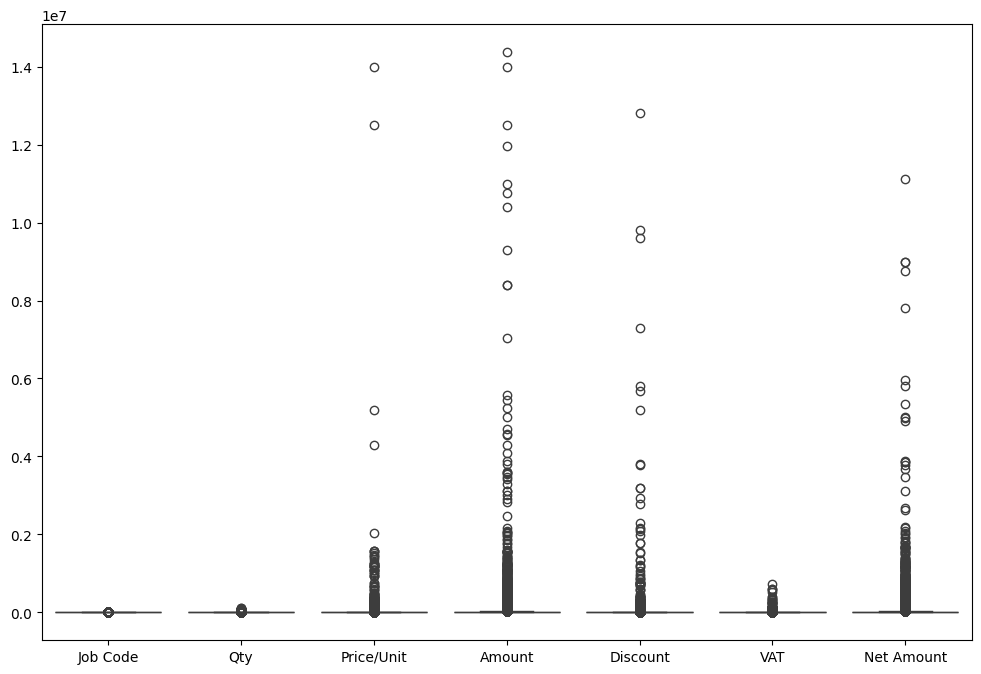

In [196]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean2, orient='v')

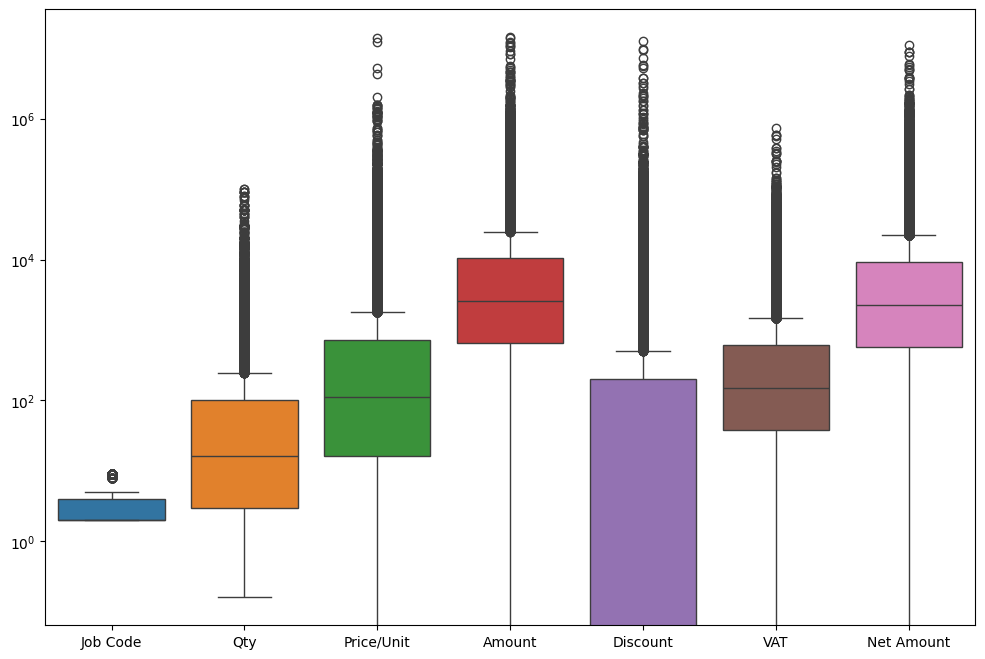

In [197]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean2, orient='v')
plt.yscale('log')

array([[<Axes: title={'center': 'P/O Date'}>,
        <Axes: title={'center': 'Job Code'}>,
        <Axes: title={'center': 'Deli. Date'}>],
       [<Axes: title={'center': 'Qty'}>,
        <Axes: title={'center': 'Price/Unit'}>,
        <Axes: title={'center': 'Amount'}>],
       [<Axes: title={'center': 'Discount'}>,
        <Axes: title={'center': 'VAT'}>,
        <Axes: title={'center': 'Net Amount'}>]], dtype=object)

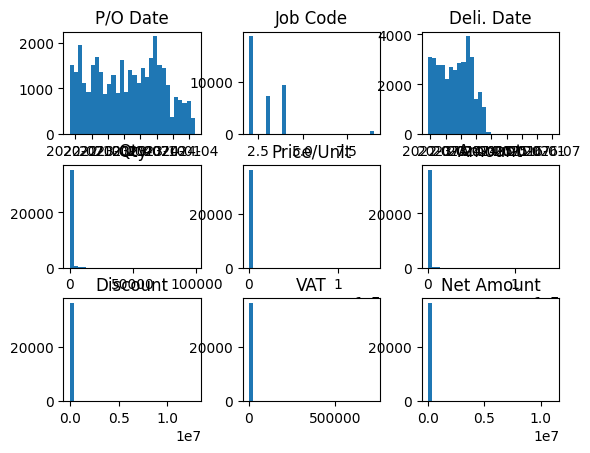

In [198]:
df_clean2.hist(grid=False, bins=30)

In [199]:
df_clean2['Delivery Days'] = abs((df_clean2['Deli. Date'] - df_clean2['P/O Date']).dt.days)

<ipython-input-199-aab39e5a6d34>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



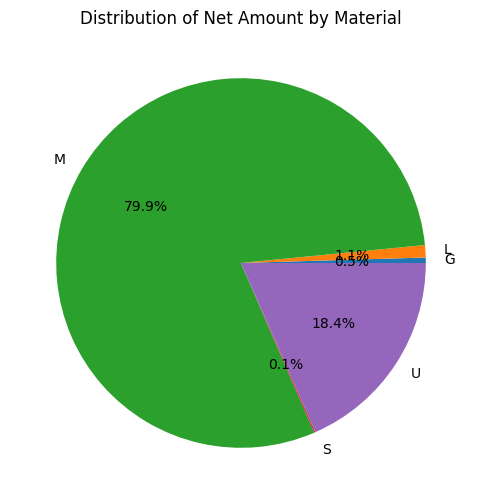

In [235]:

df_cost_code_agg = df_clean2.groupby('Cost Code')['Net Amount'].sum()
plt.figure(figsize=(6, 6))
df_cost_code_agg.plot(kind='pie', autopct='%1.1f%%')  # autopct displays the percentage value
plt.title('Distribution of Net Amount by Material')
plt.ylabel('')  # Pie charts do not typically need a y-label
plt.show()

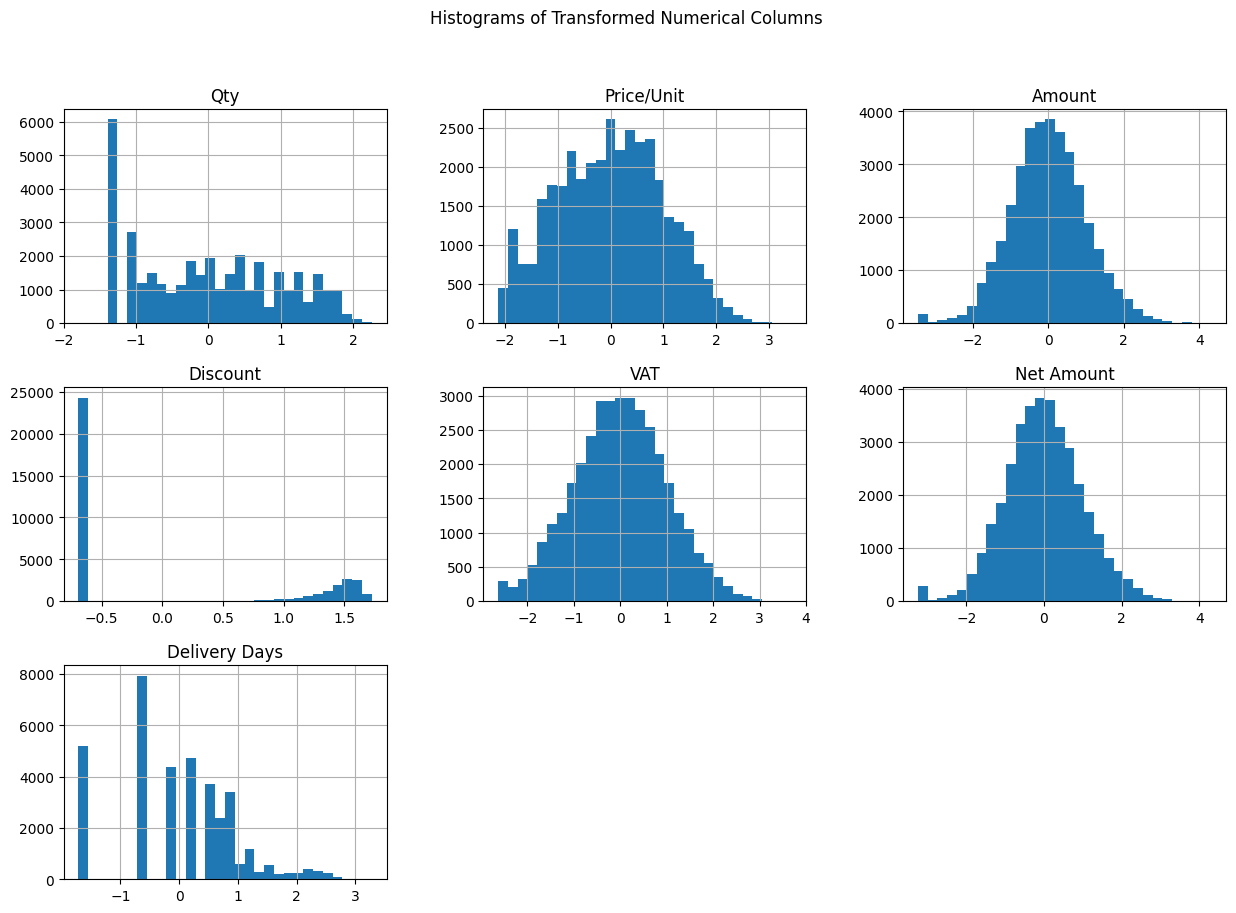

In [200]:
# Scale data

power_transformer = PowerTransformer()
df_scale = df_clean2.copy()

# List of numerical columns
numerical_cols = ['Qty', 'Price/Unit', 'Amount', 'Discount', 'VAT', 'Net Amount','Delivery Days']

# Fit and transform these columns
df_scale[numerical_cols] = power_transformer.fit_transform(df_clean2[numerical_cols])
df_scale[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Transformed Numerical Columns')
plt.show()

Now our data is ready to derive some insights

In [201]:
df_ready = df_scale.copy()

df_root = df_clean2.copy()

In [202]:
df_ready.columns

Index(['P/O No.', 'P/O Date', 'Vendor Name', 'Job Code', 'Job Name',
       'Ref.Code', 'Deli. Date', 'Cost Code', 'Material Code', 'Unit', 'Qty',
       'Price/Unit', 'Amount', 'Discount', 'VAT', 'Net Amount',
       'Delivery Days'],
      dtype='object')

# Vendor performance
I want to segment vendor based on delivering efficiency and pricings

In [239]:
selected_features = ['Delivery Days', 'Vendor Name', 'Price/Unit','Cost Code','Material Code','Job Name']

df_agg_vendor = df_ready[selected_features].groupby(['Vendor Name','Cost Code']).agg({
    'Price/Unit': 'mean',
    'Delivery Days': 'mean'
}).reset_index()

df_agg_vendor = df_agg_vendor[df_agg_vendor['Cost Code']=='M']
df_agg_vendor.nunique()

Vendor Name      169
Cost Code          1
Price/Unit       168
Delivery Days    131
dtype: int64

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

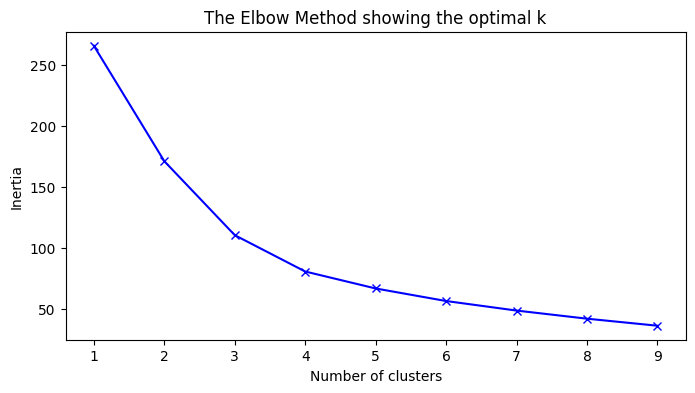

In [204]:
inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_agg_vendor[['Price/Unit', 'Delivery Days']])
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

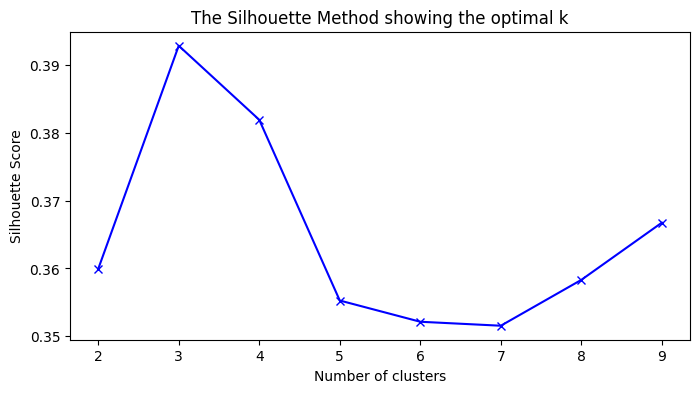

In [205]:
# Compute the silhouette scores
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(df_agg_vendor[['Price/Unit', 'Delivery Days']])
    # Silhouette score can only be calculated with more than 1 cluster
    if k > 1:
        score = silhouette_score(df_agg_vendor[['Price/Unit', 'Delivery Days']], cluster_labels)
        silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(K[1:], silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()


Choose k = 4 based on both methods and domain knowledge

In [206]:
kmeans = KMeans(n_clusters=4, random_state=11)  # Default n_init = 10 already

kmeans.fit(df_agg_vendor[['Price/Unit', 'Delivery Days']])

df_agg_vendor['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [207]:
# Plotting the clusters

df_root_agg = df_root[selected_features].groupby('Vendor Name').agg({
    'Price/Unit': 'mean',
    'Delivery Days': 'mean'
}).reset_index()

combined_df = pd.merge(df_root_agg, df_agg_vendor, on='Vendor Name', suffixes=('_root', '_scaled'))
combined_df[['Price/Unit_root', 'Delivery Days_root']] = combined_df[['Price/Unit_root', 'Delivery Days_root']].round(2)

fig = px.scatter(combined_df,
                 x='Delivery Days_scaled',
                 y='Price/Unit_scaled',
                 color='Cluster',
                 hover_data=['Vendor Name', 'Price/Unit_root', 'Delivery Days_root'],
                 labels={
                     'Cluster': 'Cluster',
                     'Price/Unit_root': 'Average Price/Unit',
                     'Delivery Days_root': 'Average Delivery Days'
                 },
                 title='Vendor Clustering Visualization')
fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig.update_layout(height=800)
fig.show()


3 groups I can interpret: slow and expensive, fast and inexpensive, fast and expensive

We need to explore what's going in with expensive and slower vendors

# Vendor Selection

Based on the clustering, we will choose the most time efficient and most cost efficient vendors to buy the material from using decision tree classifier

In [208]:
selected_features = ['Vendor Name','Cost Code','Material Code','Price/Unit','Delivery Days']

df_mat = df_ready[selected_features]
priority_mapping = {3: 1, 1: 2, 2: 3, 0: 4}  # Lower number indicates higher priority

df_mat = df_mat[df_mat['Cost Code'] == 'M']
df_mat = df_mat.merge(combined_df[['Vendor Name', 'Cluster']], on='Vendor Name', how='left')
df_mat['Priority'] = df_mat['Cluster'].map(priority_mapping)

# Select best vendors for the same material bought from different vendors from different clusters
# This will be our target

# This part computes the index of the minimum 'Priority' for each 'Material Code'
best_vendors = df_mat.loc[df_mat.groupby('Material Code')['Priority'].idxmin()]

# Create a mapping from 'Material Code' to 'Vendor Name' of the best vendor
material_best_vendor_mapping = pd.Series(best_vendors['Vendor Name'].values, index=best_vendors['Material Code']).to_dict()

# 1 for best 0 for not the best
df_mat['Is Best Vendor'] = df_mat.apply(lambda x: 1 if x['Vendor Name'] == material_best_vendor_mapping.get(x['Material Code'], None) else 0, axis=1)

df_mat[df_mat['Cluster']==2]

,Vendor Name,Cost Code,Material Code,Price/Unit,Delivery Days,Cluster,Priority,Is Best Vendor
96,บจก. ที ไอ ซี เอ็นจิเนียริ่ง,M,P3201300109001,0.841315,-0.641426,2,3,1
97,บจก. ที ไอ ซี เอ็นจิเนียริ่ง,M,P3201200107001,0.660080,-0.641426,2,3,1
98,บจก. ที ไอ ซี เอ็นจิเนียริ่ง,M,P3201200106101,0.592465,-0.641426,2,3,1
99,บจก. ที ไอ ซี เอ็นจิเนียริ่ง,M,P3201300509001,0.661611,-0.641426,2,3,1
100,บจก. ที ไอ ซี เอ็นจิเนียริ่ง,M,P3201300209001,0.562230,-0.641426,2,3,1
...,...,...,...,...,...,...,...,...
30417,บจก. ยูไอ ทรังค์กิ้ง แอนด์ เมททัล เวิร์ค,M,P3201101406001,0.638149,-1.715583,2,3,0
30418,บจก. ยูไอ ทรังค์กิ้ง แอนด์ เมททัล เวิร์ค,M,P3201201412001,0.901563,-1.715583,2,3,1
30598,บจก. เอ็นเลคทริค เซลส์,M,P3302300101004,-0.444409,1.627342,2,3,1
30599,บจก. เอ็นเลคทริค เซลส์,M,P3302300108004,-0.112145,1.627342,2,3,1


In [242]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

le = LabelEncoder()

# Encode categorical variables
df_mat['Material Code Encoded'] = le.fit_transform(df_mat['Material Code'])

# Prepare features X and target y
x = df_mat[['Material Code Encoded', 'Delivery Days', 'Price/Unit']]
y = df_mat['Is Best Vendor']

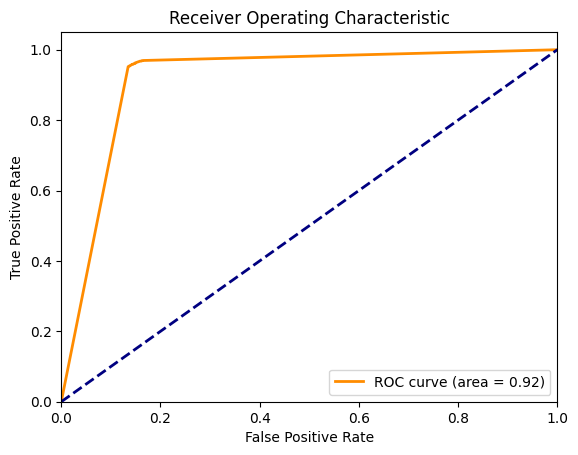

Accuracy: 0.9380905832518736
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1068
           1       0.97      0.95      0.96      5070

    accuracy                           0.94      6138
   macro avg       0.88      0.91      0.90      6138
weighted avg       0.94      0.94      0.94      6138



In [243]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

clf = DecisionTreeClassifier(class_weight='balanced', random_state = 11)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_probs = clf.predict_proba(x_test)[:, 1]  # probabilities for class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Evaluate with metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [211]:
print(f"Depth of the tree: {clf.get_depth()}")
print(f"Number of leaves: {clf.get_n_leaves()}")


Depth of the tree: 37
Number of leaves: 1839


# Cost Forecast

We want to analyze spending patterns on the building material and across sites

In [212]:
time_series_data_material = df_root.groupby(['Job Name','Cost Code', 'P/O Date'])['Net Amount'].sum().reset_index()
time_series_data_material = time_series_data_material[time_series_data_material['Cost Code'] == 'M']
time_series_data_material.set_index('P/O Date', inplace=True)
time_series_data_material = time_series_data_material[['Job Name','Net Amount']]

time_series_data_all = df_root.groupby(['P/O Date'])['Net Amount'].sum().reset_index()
time_series_data_all.set_index('P/O Date', inplace=True)
time_series_data_material

,Job Name,Net Amount
P/O Date,,
2022-06-01,AC,202009.12
2022-06-02,AC,30127.69
2022-06-06,AC,4482176.62
2022-06-07,AC,437696.12
2022-06-09,AC,82258.92
...,...,...
2024-04-17,SN,4929.49
2024-04-23,SN,5207.04
2024-04-24,SN,13806.30


## Overall costs

In [213]:
time_series_data_all.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Net Amount,510.0,1.631665e+06,3.122057e+06,432.0,293907.7475,729827.86,1516077.22,25707749.88


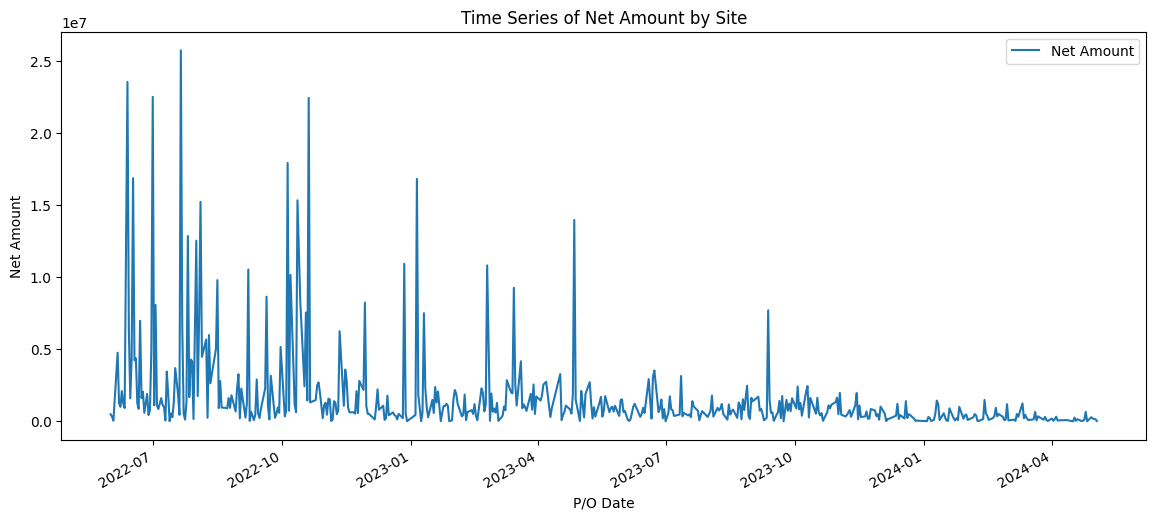

In [214]:
fig, ax = plt.subplots(figsize=(14, 6))

time_series_data_all.plot(ax = ax)

plt.title('Time Series of Net Amount by Site')
plt.xlabel('P/O Date')
plt.ylabel('Net Amount')
# plt.yscale('log')
plt.show()

Fill in missing dates

In [215]:
# Assuming df is your DataFrame and it has a DateTimeIndex
full_idx = pd.date_range(start=time_series_data_all.index.min(), end=time_series_data_all.index.max(), freq='D')
print("Missing dates:", full_idx.difference(time_series_data_all.index))

Missing dates: DatetimeIndex(['2022-06-04', '2022-06-05', '2022-06-12', '2022-06-26',
               '2022-07-31', '2022-08-06', '2022-08-07', '2022-08-12',
               '2022-08-13', '2022-08-14',
               ...
               '2024-04-10', '2024-04-12', '2024-04-13', '2024-04-14',
               '2024-04-15', '2024-04-20', '2024-04-21', '2024-04-27',
               '2024-04-28', '2024-05-01'],
              dtype='datetime64[ns]', length=193, freq=None)


In [216]:
time_series_data_all_ri = time_series_data_all.reindex(full_idx)

ts_all = time_series_data_all_ri.fillna(0)

ts_all

,Net Amount
2022-06-01,489524.58
2022-06-02,331263.51
2022-06-03,45818.00
2022-06-04,0.00
2022-06-05,0.00
...,...
2024-04-29,282865.09
2024-04-30,193316.39
2024-05-01,0.00
2024-05-02,133769.27


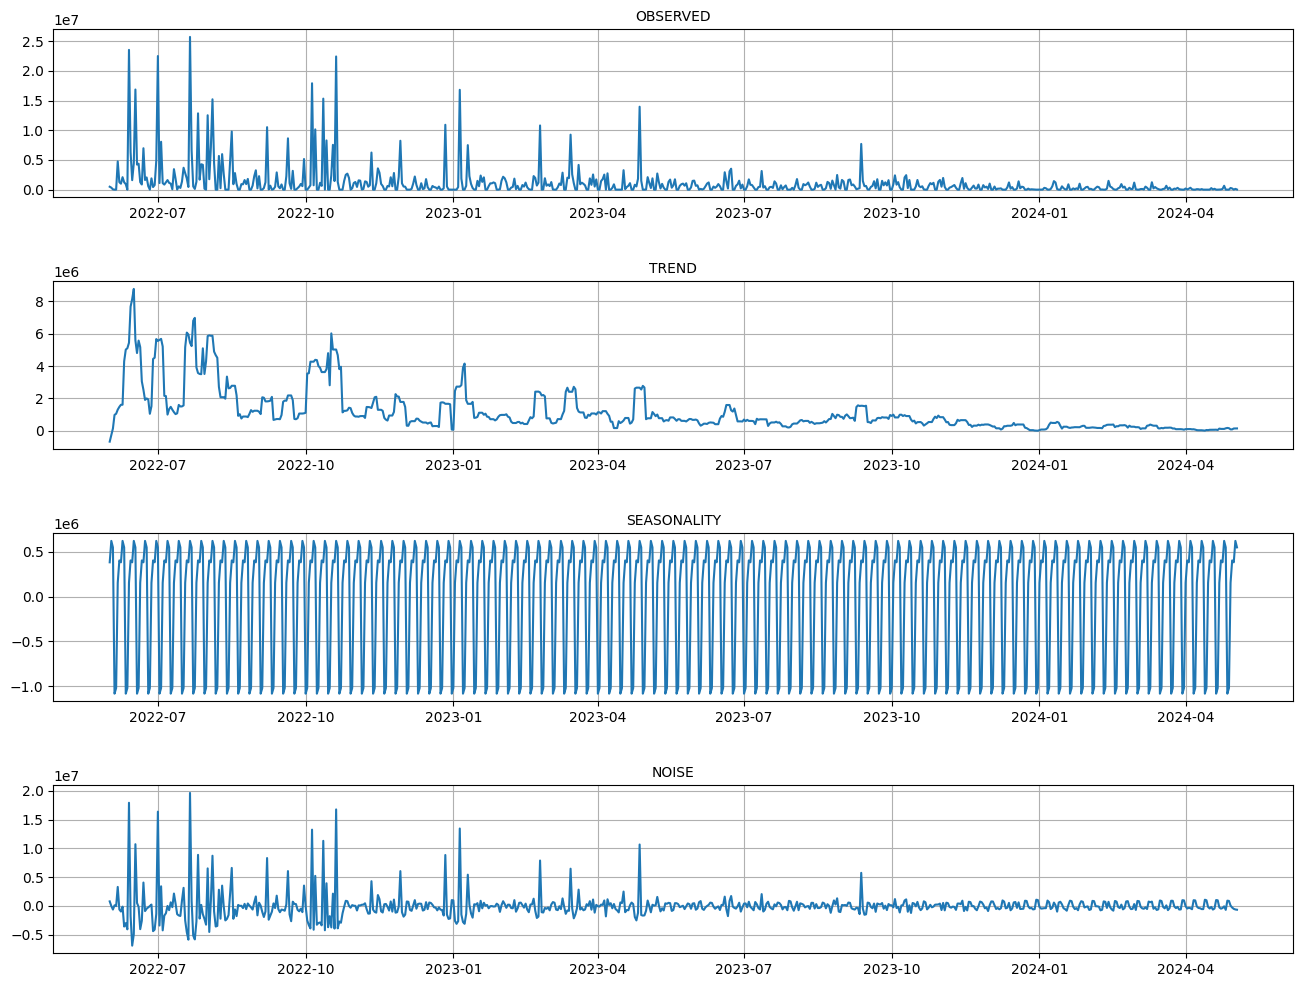

In [217]:
import statsmodels.api as sm

res=sm.tsa.seasonal_decompose(ts_all['Net Amount'],model='additive',extrapolate_trend ='freq')
fig, axs = plt.subplots(4, figsize=(16,12))
axs[0].set_title('OBSERVED', fontsize=10)
axs[0].plot(res.observed)
axs[0].grid()

axs[1].set_title('TREND', fontsize=10)
axs[1].plot(res.trend)
axs[1].grid()

axs[2].set_title('SEASONALITY', fontsize=10)
axs[2].plot(res.seasonal)
axs[2].grid()

axs[3].set_title('NOISE', fontsize=10)
axs[3].plot(res.resid)
axs[3].grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

## Materials
Jobs: 'EE', 'AC', 'SN', 'FP'

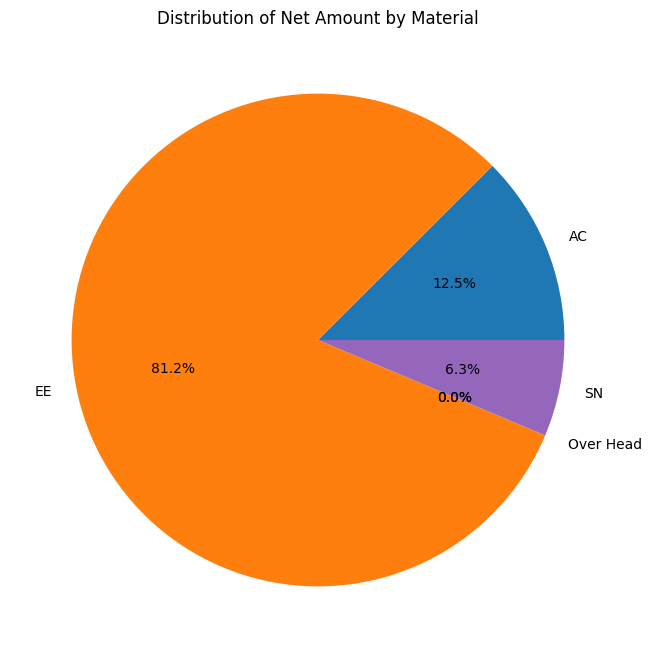

In [218]:
aggregated_data = time_series_data_material.groupby('Job Name')['Net Amount'].sum()
plt.figure(figsize=(8, 8))
aggregated_data.plot(kind='pie', autopct='%1.1f%%')  # autopct displays the percentage value
plt.title('Distribution of Net Amount by Material')
plt.ylabel('')  # Pie charts do not typically need a y-label
plt.show()

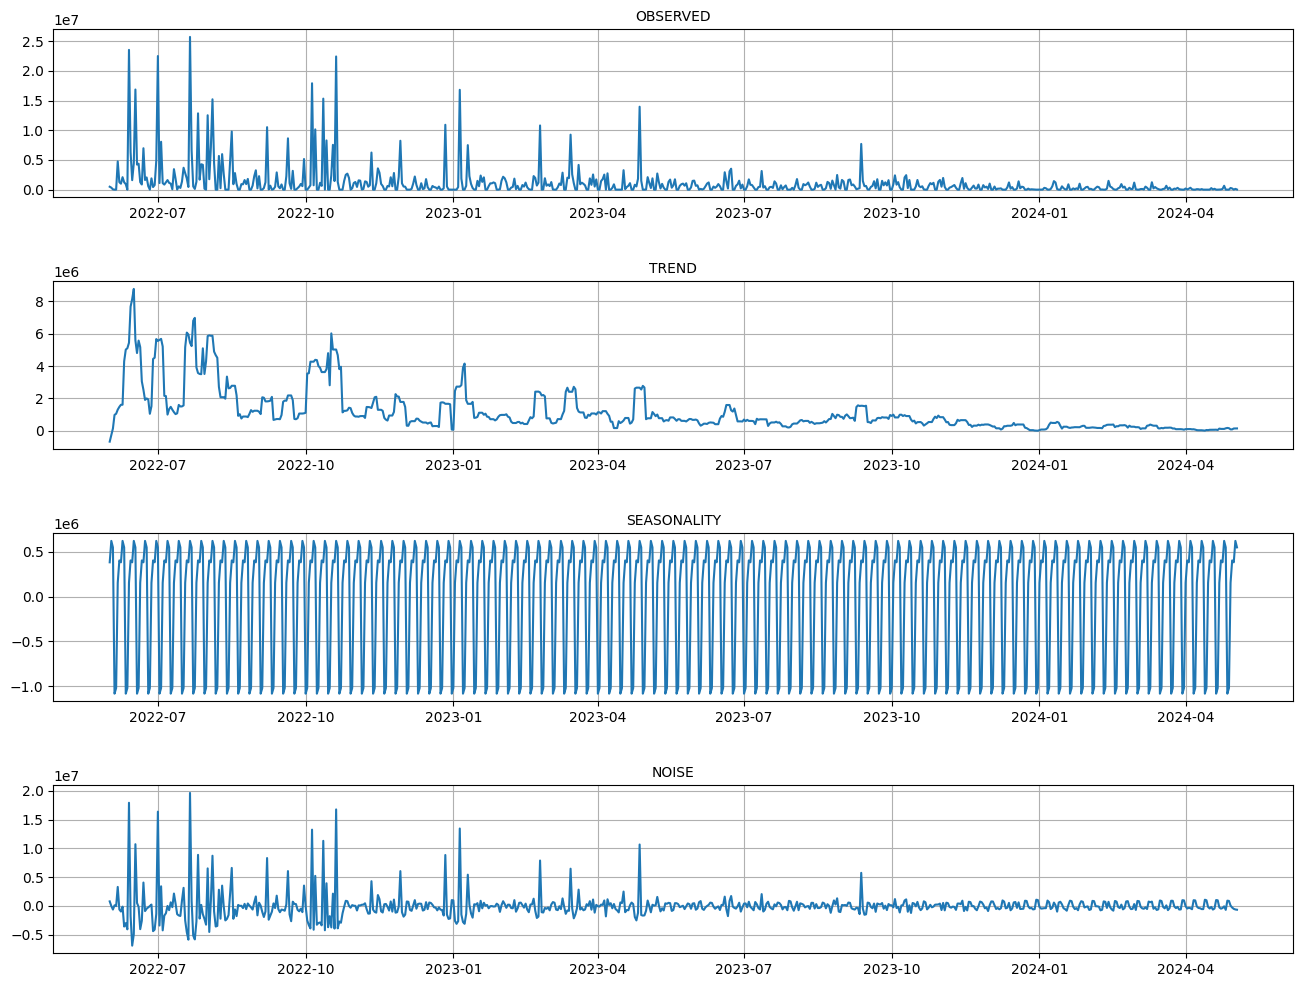

In [219]:
ts_ac = time_series_data_material[time_series_data_material['Job Name']=='EE']

full_idx = pd.date_range(start=ts_ac.index.min(), end=ts_ac.index.max(), freq='D')
ts_ac = ts_ac.reindex(full_idx)
ts_ac = ts_ac.fillna(0)

res=sm.tsa.seasonal_decompose(ts_all['Net Amount'],model='additive',extrapolate_trend ='freq')
fig, axs = plt.subplots(4, figsize=(16,12))
axs[0].set_title('OBSERVED', fontsize=10)
axs[0].plot(res.observed)
axs[0].grid()

axs[1].set_title('TREND', fontsize=10)
axs[1].plot(res.trend)
axs[1].grid()

axs[2].set_title('SEASONALITY', fontsize=10)
axs[2].plot(res.seasonal)
axs[2].grid()

axs[3].set_title('NOISE', fontsize=10)
axs[3].plot(res.resid)
axs[3].grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

# Benchmark w number of construction in thailand
# Doing bad no proj

# Economic recession 2022-now after gov support

In [220]:
cutoff_percentage = 0.9
cutoff_index = int(len(ts_ac) * cutoff_percentage)

# Split the data into training and testing sets
train_data = ts_ac.iloc[:cutoff_index]
test_data = ts_ac.iloc[cutoff_index:]

Removing outlier that unecessary contradict the trend and affects the evaluation

<ipython-input-221-cd31fed10edd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



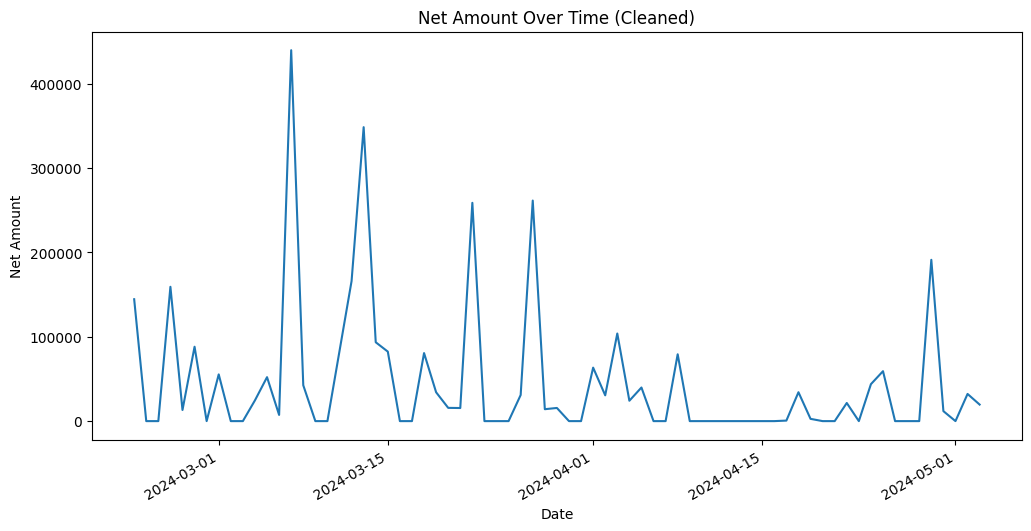

In [221]:
test_data['Z-Score'] = (test_data['Net Amount'] - test_data['Net Amount'].mean()) / test_data['Net Amount'].std()

# Filter the data points where the absolute Z-Score is greater than 3 (common threshold for outliers)
outliers_z = test_data[np.abs(test_data['Z-Score']) > 3]

test_data = test_data[np.abs(test_data['Z-Score']) <= 3]


test_data['Net Amount'].plot(kind='line', figsize=(12, 6), title='Net Amount Over Time (Cleaned)')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.show()

In [222]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['Net Amount'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.010257839905404
n_lags: 0.03394748831599332
p-value: 0.03394748831599332
Critial Values:
   1%, -3.4410802944179686
Critial Values:
   5%, -2.8662741915097736
Critial Values:
   10%, -2.569291225276603


Non stationary, so differencing needed

In [223]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(sm.tsa.statespace.tools.diff(train_data['Net Amount'],k_diff=1,k_seasonal_diff=None, seasonal_periods=1), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.848992915989806
n_lags: 7.2839446211127535e-22
p-value: 7.2839446211127535e-22
Critial Values:
   1%, -3.4410802944179686
Critial Values:
   5%, -2.8662741915097736
Critial Values:
   10%, -2.569291225276603


<ipython-input-224-a797ae5091ad>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



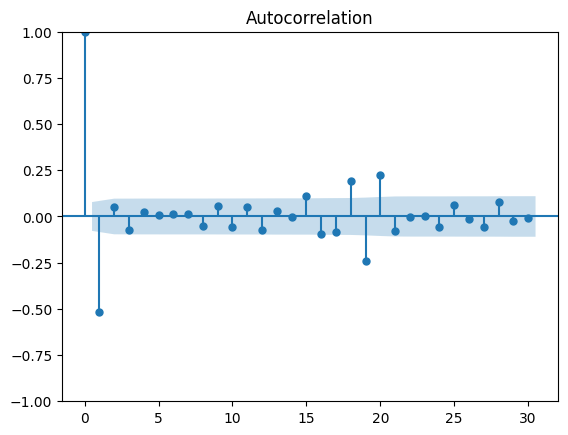

In [224]:
train_data['p_d1'] = sm.tsa.statespace.tools.diff(train_data['Net Amount'],k_diff=1,k_seasonal_diff=None, seasonal_periods=1)
sm.graphics.tsa.plot_acf(train_data['p_d1'][1:],lags=30)
plt.show()

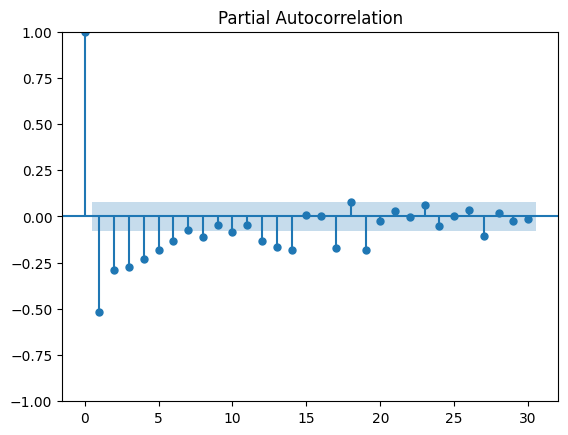

In [225]:
sm.graphics.tsa.plot_pacf(train_data['p_d1'][1:],lags=30)
plt.show()

In [226]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train_data['Net Amount'],order=(19,1,1),missing='drop')
result=model.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Net Amount   No. Observations:                  632
Model:                ARIMA(19, 1, 1)   Log Likelihood              -10125.708
Date:                Sun, 05 May 2024   AIC                          20293.416
Time:                        14:53:44   BIC                          20386.809
Sample:                    06-01-2022   HQIC                         20329.690
                         - 02-22-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8105      0.166     -4.886      0.000      -1.136      -0.485
ar.L2         -0.7753      0.163     -4.764      0.000      -1.094      -0.456
ar.L3         -0.8080      0.153     -5.270      0.000      -1.109      -0.507
ar.L4         -0.7433      0.152     -4.882      0.000      -1.042      -0.445
ar.L5         -0.7058      0.145     -4.852      0.000      -0.991      -0.421
ar.L6         -0.6589      0.142     -4.646      0.000      -0.937      -0.381
ar.L7         -0.6449      0.131     -4.930      0.000      -0.901      -0.389
ar.L8         -0.6528      0.123     -5.309      0.000      -0.894      -0.412
ar.L9         -0.6354      0.123     -5.168      0.000      -0.876      -0.394
ar.L10        -0.6524      0.123     -5.298      0.000      -0.894      -0.411
ar.L11        -0.6333      0.119     -5.312      0.000      -0.867      -0.400
ar.L12        -0.6490      0.112     -5.774      0.000      -0.869      -0.429
ar.L13        -0.5863      0.115     -5.119      0.000      -0.811      -0.362
ar.L14        -0.4343      0.108     -4.038      0.000      -0.645      -0.223
ar.L15        -0.2763      0.083     -3.331      0.001      -0.439      -0.114
ar.L16        -0.3262      0.057     -5.686      0.000      -0.439      -0.214
ar.L17        -0.3258      0.044     -7.402      0.000      -0.412      -0.240
ar.L18        -0.1179      0.044     -2.682      0.007      -0.204      -0.032
ar.L19        -0.2250      0.015    -15.015      0.000      -0.254      -0.196
ma.L1         -0.1388      0.175     -0.795      0.427      -0.481       0.203
sigma2      4.125e+12   3.76e-13    1.1e+25      0.000    4.13e+12    4.13e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             30620.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             4.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.55e+40. Standard errors may be unstable.
"""

In [227]:
pred=result.predict(start=test_data.iloc[0].name, end=test_data.iloc[-1].name)
test_data['pred_arima']=pred
test_data

# train_data['pred_arima']=pred
# train_data

,Job Name,Net Amount,Z-Score,pred_arima
2024-02-23,EE,144530.04,0.535228,48753.748642
2024-02-24,0,0.00,-0.394405,61033.944778
2024-02-25,0,0.00,-0.394405,68433.264992
2024-02-26,EE,159271.48,0.630046,99925.635079
2024-02-27,EE,13215.64,-0.309401,68923.026639
...,...,...,...,...
2024-04-29,EE,191277.37,0.835912,56446.783128
2024-04-30,EE,11823.50,-0.318355,56302.685325
2024-05-01,0,0.00,-0.394405,58928.982869
2024-05-02,EE,32215.77,-0.187190,53618.128985


In [228]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

print('MAE:', mean_absolute_error(test_data['Net Amount'],test_data['pred_arima']))

MAE: 60872.28194585041


The MAE, 60,872.28, when compared to a maximum possible value of 25,000,000, represents approximately 0.243% of the maximum value. This proportion is relatively small, suggesting that the average error per prediction is quite minor in relation to the scale of the data.

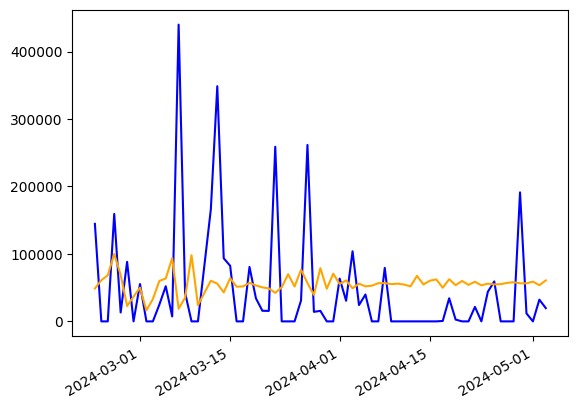

In [229]:
test_data['Net Amount'].plot(color='blue')
test_data['pred_arima'].plot(color='orange')
plt.show()

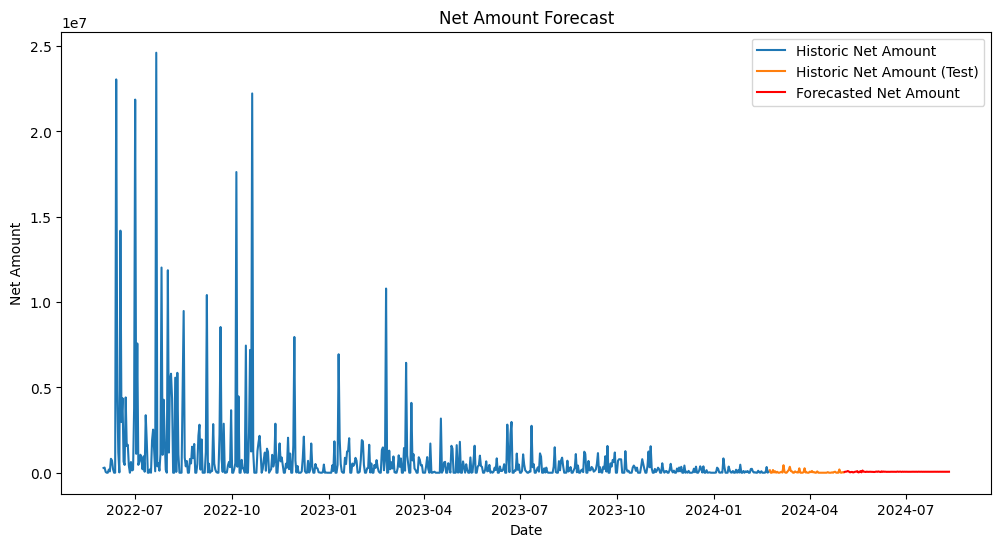

In [230]:
forecast = result.forecast(steps=100)
last_date = test_data.index[-1]
date_range = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=100, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Net Amount'], label='Historic Net Amount')
plt.plot(test_data.index, test_data['Net Amount'], label='Historic Net Amount (Test)')
plt.plot(date_range, forecast, label='Forecasted Net Amount', color='red')
plt.title('Net Amount Forecast')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.show()